# ISI SPRING 2019 RESEARCH PROJECT

* By: Huy Nghiem
* Assingment for the spam classifcation project for the USC MINDS research group.
* TASK: Classify whether e-mails are spams or not and produce metrics for model performance. 

## Data Import
* Source: http://archive.ics.uci.edu/ml/datasets/Spambase (Visit for more information)
* Expect data to have 4,601 emails with 1813 are spam (39.4%).
* From the source, we know that a spam corresonds to value of 1, whereas non-spam is 0, pretty intuitive intepretation.

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
%load_ext autoreload
%matplotlib inline

In [3]:
df = pd.read_csv("spambase.data", header=None)
print("This set contains %s rows and %s columns" % (df.shape))
df.head()

This set contains 4601 rows and 58 columns


,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


## Observation
The repository also gives us the names of each feature. We opt not to
focus on variables' names, as we want to dive into analysis, but subsequent 
analysis of importance is also feasible.

Note that most of the features are frequency of certain spam-associated words. Some other features are average length of special sequences (ex: all capital).

In [4]:
#Get the distribution of spams in the entire set.
df.loc[:,57].value_counts()

0    2788
1    1813
Name: 57, dtype: int64

From the dataset description and the prompt, the number of features and the breakdown of spams vs non-spams look correct. Proceed to next step.

## Data Exploration
Since this is spam classification task, we do not want to misclassify an email as a spam when it is in fact not. In other words, we probably prefer a low False Positve Rate over a low False Negative Rate, if we had to pick. We'll keep this in mind for model building.

In [90]:
#The variables are all numeric.
t = pd.DataFrame(df.dtypes).T
pd.unique(t.values[0])

array([dtype('float64'), dtype('int64')], dtype=object)

In [12]:
#Check for missingness in each variable
print(df.isnull().any().astype(int).sum())
print(np.isnan(df.values).any().astype(int).sum())
#Looks like no missing values. Great!

0
0


### Check for variance

In [5]:
desc = df.describe().T
desc['range'] = (desc["max"] - desc["min"]).abs()
#Select top 10 variables with the larget range
desc.sort_values("range", ascending=False)[:10]
# .sort_values(["min","max"])

,count,mean,std,min,25%,50%,75%,max,range
56,4601.0,283.289285,606.347851,1.0,35.000,95.000,266.000,15841.000,15840.000
55,4601.0,52.172789,194.891310,1.0,6.000,15.000,43.000,9989.000,9988.000
54,4601.0,5.191515,31.729449,1.0,1.588,2.276,3.706,1102.500,1101.500
3,4601.0,0.065425,1.395151,0.0,0.000,0.000,0.000,42.810,42.810
26,4601.0,0.767305,3.367292,0.0,0.000,0.000,0.000,33.330,33.330
51,4601.0,0.269071,0.815672,0.0,0.000,0.000,0.315,32.478,32.478
45,4601.0,0.179824,0.911119,0.0,0.000,0.000,0.000,22.050,22.050
44,4601.0,0.301224,1.011687,0.0,0.000,0.000,0.110,21.420,21.420
24,4601.0,0.549504,1.671349,0.0,0.000,0.000,0.000,20.830,20.830
15,4601.0,0.248848,0.825792,0.0,0.000,0.000,0.100,20.000,20.000


Obs: The ranges of each variable are diverse, consistent with the fact that most of the set are continuous variables (frequency).

### Quick check for correlation

In [6]:
#Get the indices to be mapped
pairs = set()
c = df.columns
for i in range(df.shape[1]):
    for j in range(0,i+1):
        pairs.add((c[i], c[j]))
        
#Get the corrlation result
corr = df.corr().abs().unstack()
corr_t = corr.drop(labels=pairs).sort_values(ascending=False)
corr_t[:20]

31  33    0.996066
    39    0.848021
33  39    0.845359
30  31    0.737555
    33    0.735187
31  35    0.729750
33  35    0.727119
30  39    0.699918
    35    0.677790
35  39    0.674249
29  31    0.660284
    33    0.657941
    35    0.626124
    30    0.607214
    39    0.602230
27  34    0.581518
    35    0.565162
    31    0.559349
    33    0.557573
31  34    0.556650
dtype: float64

It appears that variables with indces 30,31,33,35,39 are highly correlated. Verify
this fact by specifically indexing them

          30        31        33        35        39
30  1.000000  0.737555  0.735187  0.677790  0.699918
31  0.737555  1.000000  0.996066  0.729750  0.848021
33  0.735187  0.996066  1.000000  0.727119  0.845359
35  0.677790  0.729750  0.727119  1.000000  0.674249
39  0.699918  0.848021  0.845359  0.674249  1.000000


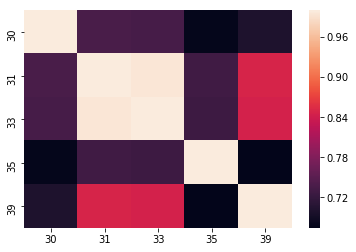

In [88]:
corr_s = df.loc[:,[30,31,33,35,39]].corr()
print(corr_s)
sns.heatmap(corr_s)

Observation suggests that we should keep var 33 and drop 31,39 due to extremely high
correlation. Keep this in mind when building model.

*END OF EXPLORATION; GO TO "MODEL BUILDING" FOR MODULE...